In [3]:
from onsort.discrete_prob import plot_p_dist, P_print, pnb, P, hyp
from sympy import Sum, Symbol, plot, solve, Float, Function, lambdify
from onsort.my_sort import InfinitesimalSort, n1
from matplotlib import pyplot as plt
import numpy as np

In [5]:
def plot_real_p(buckets, items):
    x = np.arange(buckets)
    for i in range(items):
        y = [pnb(buckets, items, b, i) for b in range(buckets)]
        plt.plot(x, y)

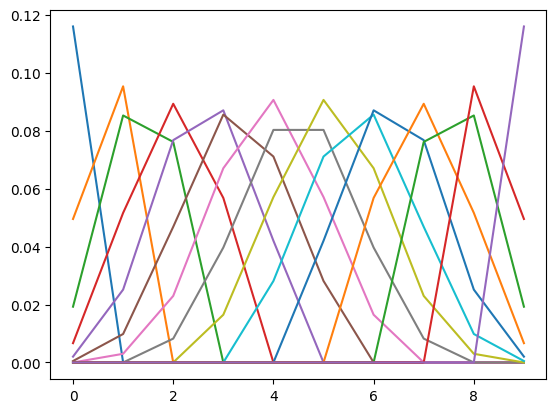

In [12]:
plot_real_p(10,15)

In [8]:
P(3,4) # todo make by hand! 

3/4

In [59]:
P(2,3)

5/6

In [60]:
pnb(3,4,0,0) # hyp hyp(3,4,0,0) = 1 

5/6

In [69]:
def pnb(buckets:int, items:int, b:int, n:int) -> Float:
    """ Probability of winning with optimal strategy given that you place
    item at place b
    """
    print(b, n-1)
    return hyp(buckets, items, b, n) * P(b, n) * P(buckets - 1 - b, items - n - 1)


In [70]:
pnb(3,4,2,3)### !!! what???  hyp(3,4,2,3) 1   [_][_][3]
# []

2 2


5/6

1

In [17]:
pnb(3, 4, 0, n1)

TypeError: '>' not supported between instances of 'dict' and 'int'

In [14]:
plot_p_dist2(3,10)

TypeError: '>' not supported between instances of 'dict' and 'int'

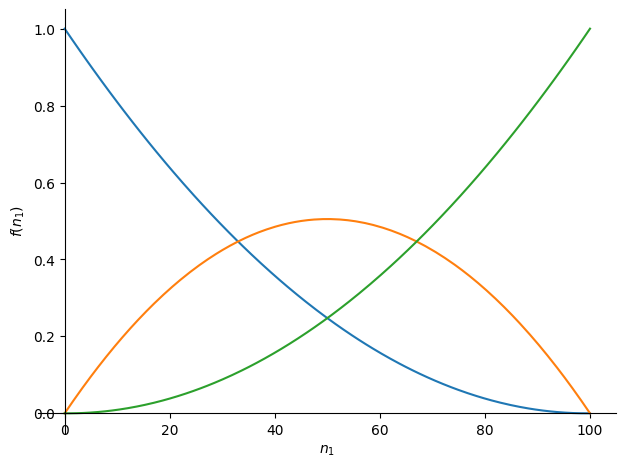

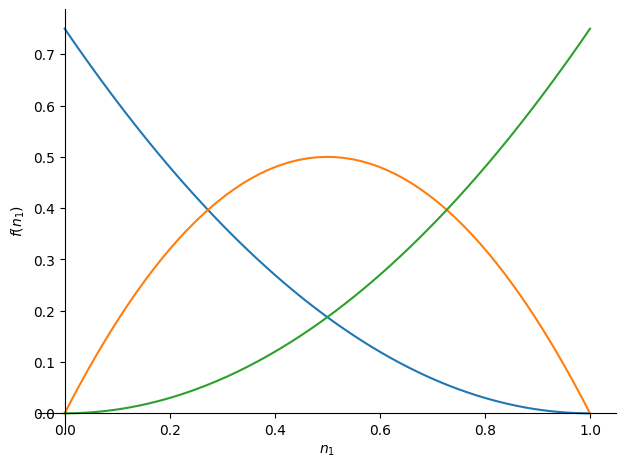

In [13]:
plot_p_dist(3,101)
plot(*InfinitesimalSort(False).p_distributions(3), (n1,0,1))

In [3]:
P_print()

Sum(P(b1, n1 - 1)*P(B - b1 - 1, I - n1 - 1)*binomial(n1, b1)*binomial(I - n1 - 1, B - b1 - 1)/binomial(I - 1, B - 1), (n1, optmin(b1, B, I), optmax(b1, B, I)), (b1, 0, B - 1))/I

In [10]:
InfinitesimalSort(False).p_distributions(4)

[0.519283746556474*(1.0 - n1)**3,
 2.25*n1*(1.0 - n1)**2,
 0.75*n1**2*(3.0 - 3.0*n1),
 0.519283746556474*n1**3]

In [ ]:
bucket = 1
items = 1000
item = 500
trials = 2
assert items>item, "itemas > item"
print("buckets:", trials+1)
print(f"Items: 0-{items-1}: \n" + "".join("[_]" if i!=bucket else f"[{item}]" for i in range(trials+1)))
print()
print(f"Items: 0-{1}: \n" + "".join("[_]" if i!=bucket else f"[{item/items:f}]" for i in range(trials+1)))

print(density(Hypergeometric('H', items-1, item, trials))(bucket).evalf())
density(Binomial("X", trials, item/items))(bucket)

In [ ]:
@lru_cache
def pb(buckets: int, items: int, bucket: int):
    trials = buckets -1 
    return density(Hypergeometric('H', items-1, n1, trials))(bucket)

def opt(buckets:int, items:int):
    sols= [0]
    current = 0 
    for i in range(0, buckets):
        sol=solve(pb(buckets, items,i)-pb(buckets, items, i+1))
        for j in sol:
            if j> current:
                sols.append(j)
                current = j
                break
        # print(sol)
    sols.append(items-1)
    return sols

def int_opt(buckets, items):
    opts = (int(i) for i in opt(buckets, items))
    i = next(opts)
    for k in opts:
        f = k if k>i else i
        yield i,f
        i = f+1

@lru_cache
def P(buckets, items):
    #print(f"P({buckets},{items})")
    # min included max not included, as python convention

    if buckets in (0,1):
        return 1
    if items == buckets: # good but take out for testing everything works
        return 1 
    if items < buckets:
        return 1
    s = 0
    opts = int_opt( buckets, items)
    
    for b in range(buckets):
        mi, ma= next(opts)
        #print(f"P({buckets},{items})","mi,ma",mi,ma)
        nv = 0
        for n in range(mi, ma+1):
            v = pb(buckets, items, b).subs({n1:n})* P(b, n-1) * P(buckets-1-b, items-n-1)
            nv+=v
            #print(f"P({buckets},{items}) {b=} {n=} {v=}" , "cont:", pb(buckets, items, b).subs({n1:n}) , f"{v=}")
            #print(nv)
        s+=nv
        # print(f"{s=}")
    #print("final")
    #print(f"{s=}")
    #print()
    return s / items

In [ ]:
class opt_min(Function):
    @classmethod
    def eval(cls, n, buckets, items):
        # print('min', n)
        if n == 0:
            return 0
        else:
            sol = solve(pb(n, items, buckets)-pb(n-1, items, buckets))
            return floor(sol[0])+1
        